### Mean Reversion Strategy
This aims to take advantage of the relative volatility between two commodities, in this case Bitcoin and Ethereum. The strategy aims to trade the pair, so, if Bitcoin is cheap compared to Ethereum, you sell Ethereum to buy Bitcoin, then when the market stabilises you sell the Bitcoin and buy back the Ethereum, and pocket the difference.

The question then becomes, how do we determine if there is a big enough price difference to take advantage of this and how can we tell if there is a difference? 

Well we compare the Bitcoin and Ethereum prices, and when the current price is significantly outside of the normal range for a period (mean), in this case 50 time stamps, you generate a trading signal to do the trade. When this reverts back to the mean, you close the trade. We can use a combination of basic statistics and the principal of a stationary of a time series and cointegration to find this out. 


***

### Pre-Work

#### Basic Statistics
Mean: The sum of the items divided by the amount of items. We extend this further by looking at a rolling mean, where we do this over a specific period instead of the entire dataset, in this case 50 time stamps.

Standard Deviation: This looks at how far away from the mean the data point is. We will also perform this over a rolling window, so the value changes as we move along the dataset, in this case 50 time stamps.

Z-Score: How many standard deviations the data point is away from the mean. So in this context, how far away from the mean the current point is in the current 50 time stamp window. This is a useful measure of how different the relative prices of the two commodities are compared to their normal relative difference. 

#### Stationary Time Series and Cointegration
A stationary time series is something we need to perform a good analyses on timeseries data. A stationary time series is one which the value does not depend on the time at which the series is observed. So, a time series with seasonality is not stationary as the seasonality will affect the value of the time series at different times. So we often have to perform operations on a timeseries to make it stationary.

The technique of cointegration aims to find a possible correlation that is stationary between two timeseries datasets over an extended period of time, where the mean value is about 0. The resulting analyses lets us generate a single time series using Formula 1, where y and x are the time series values for Bitcoin and Ethereum; which represents the modified price difference between the commodities.

Formula 1: cointegration spread $= y - \beta x$

We will use the Augmented Dickey Fuller (ADF) test to determine if the two time series datasets are cointegrating as well as to determine $\beta$. The ADF test is performed using regression and returns a P-Value for how confidently we can say the series is cointegrating. If the P-Value is below 0.05, we can be confident the timeseries generated by Formula 1 using out value for beta will be cointegrating, and therefore suitable for a mean reversion strategy. 

We then apply Formula 1 to our two timeseries datasets, we will then get a single timeseries that is staionary and cointegrating. This means we can analyses trends and differences from the mean of zero, which represent how far away from the mean the two pairs are, to take advantage of their relative price differences. This is done using the Z-Score of the resulting cointegrating spread determined by Formula 1. 

***

### Putting It Together
So based on this, we need to convert our Bitcoin and Ethereum data into a single time series with a mean of about 0, to then perform our mean reversion strategy. Now not all commodites have this property, so we have to do some research to find this out, this is the goal of this notebook.

So, now we have the stationary time series made up of our Bitcoin and Ethereum data, we can perform some basic statistics on this, this will be finding the rolling Z-Score for the data, for a 50 time step window. This will allow us to compare a time stamp with the previous 49 to see if it is outside of the mean. If the Z-Score for a point is over 2.0 or below -2.0, we have a sufficient difference between Bitcoin and Ethereum to generate a trading signal, this then performs our trade.

***

## Functions
This section sets our functions to use.

In [1]:
import statsmodels.api as sm
from binance.client import Client
import json
import pandas as pd
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import matplotlib.pyplot as plt

In [40]:
# Determines the cointegration from formula 1.
def find_coint_spread(x, y, df, graphing=False):
    model = sm.OLS(y, x)
    model = model.fit()
    
    beta = model.params[0]

    df["Coint Spread"] = y - beta*x
    
    if graphing:
        plt.plot(spread)
        plt.show()
    
    return df, beta
        

# Test for cointegration of the spread
def test_coin(spread):
    adf = sm.tsa.stattools.adfuller(spread, maxlag=1)
    adf_out = adf[0]
    p_value = adf[1]
    
    return p_value, adf_out


# Statistical analyses of the cointegration spread
def do_analysis(spread, df, graphing=True):
    df["Mean"] = spread.rolling(window=50).mean()
    df["STD"] = spread.rolling(window=50).std()
    df["Z-Score"] = (spread - df["Mean"])/df["STD"]
    
    if graphing:

        buy_point = df["Z-Score"].copy()
        sell_point = df["Z-Score"].copy()

        buy_point[buy_point > -1.8] = None
        sell_point[sell_point < 1.8] = None

        buy_point.plot(color="g", linestyle="None", marker="^")
        sell_point.plot(color="r", linestyle="None", marker="^")      
        plt.plot(df["Z-Score"][-200:])
        plt.title("ETH vs BTC - Z-Score")
        plt.xlabel("Timestamps")
        plt.ylabel("Z-Score")
        plt.savefig("graph.png")
        plt.show()
    
    return df


# Generate the required features 
def feature_generation(pair1):
    data_df = pd.DataFrame(columns=["Pair 1", "Pair 2", "Coint Spread", "Mean", "STD", "Z-Score"])

    pair_1 = get_history(pair1)
    pair_2 = get_history("BTC")

    pair_1_close = pair_1[-min(len(pair_1), len(pair_2)):].reset_index().drop("index", axis=1).copy()
    pair_2_close = pair_2[-min(len(pair_1), len(pair_2)):].reset_index().drop("index", axis=1).copy()
    data_df["Pair 1"] = pair_1_close
    data_df["Pair 2"] = pair_2_close
    
    x = np.log(data_df["Pair 1"])  
    y = np.log(data_df["Pair 2"])

    data_df, beta = find_coint_spread(x, y, data_df)
    data_df = do_analysis(data_df["Coint Spread"], data_df)
    data_df = data_df.dropna()

    p_value, adf_out = test_coin(data_df["Coint Spread"])

    return p_value, beta, data_df["Coint Spread"] 

# Use the Binance API to get the data
def get_history(instrument):
    client_history = Client()

    k_lines = client_history.get_historical_klines(f"{instrument}AUD", Client.KLINE_INTERVAL_5MINUTE, "1 Jan 2021", "1 Jan 2023")

    
    df = pd.DataFrame(k_lines, columns=["Open time", "Open", "High", "Low", "Close", "Volume", "Close time",
                                        "Quote asset volume", "Number of trades", "Taker buy base asset volume",
                                        "Taker buy quote asset volume", "Ignore"])
    df_out = df["Close"].astype("float64")

    return df_out


# Save the resulting information to a .json file
def save_to_json(dict_in):
    with open("analysis_values.json", "w") as outfile:
        json.dump(dict_in, outfile)

***

## Main Script
This section combines our above functions to run the script and generate an output.

In [41]:
# Run the analyses on a pair with Bitcoin as the base currency
def run_pairs(pairs):
    instrument_choices = set()
    
    analysis_dict = {}
    
    spread_list = []
    
    for item in pairs:
        p_value, beta, spread_out = feature_generation(item)
        spread_list.append(spread_out)
        analysis_dict[item] = (p_value, beta)

        instrument_choices.add((f"BTC-USD", f"{item}-USD"))
        print(f"Instrument: {item}/BTC - P-Value: {round(p_value,5)} - Beta: {beta}")

    return analysis_dict, spread_list

In [42]:
# Trading pairs to use that pair with Bitcoin
pairs = ["ETH"]

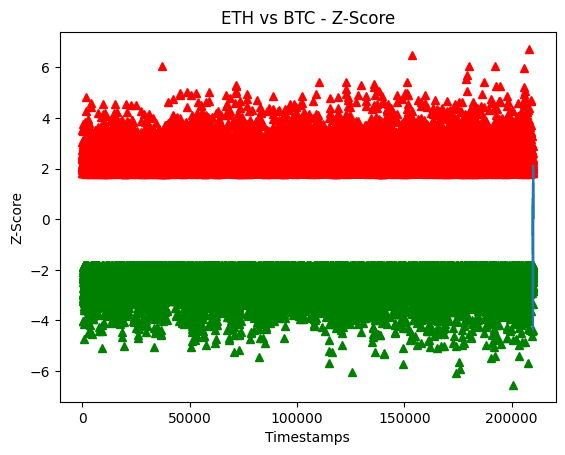

Instrument: ETH/BTC - P-Value: 0.00609 - Beta: 1.3447598801743639


In [43]:
# Running the analyses
analysis_dict, spread_out = run_pairs(pairs)

# Saving the data
save_to_json(analysis_dict)

In [44]:
# Test the .json file loads and opens correctly
with open('analysis_values.json', "r") as f:
    data = json.load(f)

eth_beta = data["ETH"][1]
for pair in pairs:
    print(pair, data[pair])

ETH [0.006090193262582024, 1.3447598801743639]
